# Using CAMB for Powers spectra
In this notebook, 
- compute and display the Power Spectrum prediction from CAMB

CAMB is described here: https://camb.readthedocs.io and is a requirement for the comparison. This notebook uses the CosmoUtils library, also available on the wiki.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower

### Cosmological Parameters
Ob is set to a low value to mimick Dark-Matter Only simulation

In [2]:
H0=67.00 # km/s/Mpc
h=H0/100. # reduced hubble parameter
s8=0.8344 # sigma 8
ns=0.96 # slope of primordial power spectrum
ob=0.002
# ob=0.02/h**2
om=0.3175
ov=1.0-om 
z=0.0

CAMB Theory

In [3]:
# First we have to set CAMB to use the right normalisation using sigma8 (instead of As)
# We start by giving a bogus As that returns a fiducial s8
# and then we rescale As using the s8 that we want (good As) = (bogus As)*s8**2/(s8_fid)**2

As=2e-9 # fiducial normalisation before proper renormalisation
pars =  camb.set_params(H0=H0, ombh2=ob*h**2, omch2=(om-ob)*h**2, ns=ns,As=As,omk=0.0)
pars.set_matter_power(redshifts=[0.,z+1e-6], kmax=40.0)
results = camb.get_results(pars)
s8_fid = results.get_sigma8_0()
# now set correct As using As \propto sigma8**2.
sigma8 = s8 # value we want
pars.InitPower.set_params(As=As*sigma8**2/s8_fid**2, ns=ns)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.,z+1e-6], kmax=40.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, zcamb, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1e1, npoints = 200)
s8new = np.array(results.get_sigma8())
print(s8new)

#Non Linear spectra
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
kh_nl, zcamb_nl, pk_nl = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1e1, npoints = 200)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
[0.83439956 0.8344    ]


## PLOT

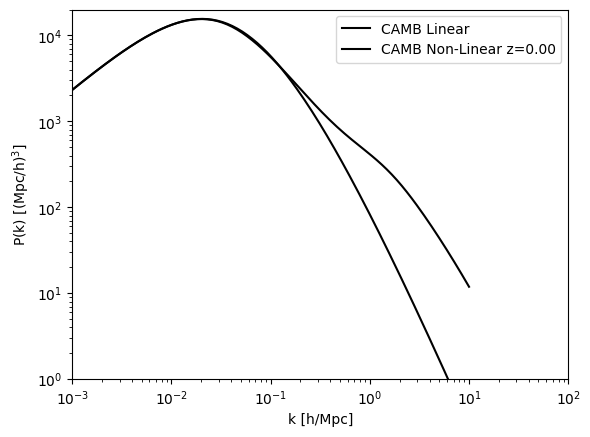

In [4]:
plt.figure()
plt.loglog(kh,pk[-1,:],'k',label='CAMB Linear')
plt.loglog(kh_nl,pk_nl[-1,:],'k',label='CAMB Non-Linear z={:4.2f}'.format(z))

plt.ylim([1e0,2e4])
plt.xlim([1e-3,100])
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P(k) [(Mpc/h)$^3$]')
plt.legend()

## Let's Compute sigma 8 at current redshift z

In [5]:
import scipy.integrate as integ
# We compute sigma 8 for cross-check
R=8 #Mpc/h

x=kh*R
w=3*(np.sin(x)-x*np.cos(x))/x**3
pconv=pk[-1,:]/(2*np.pi)**3 # we convert PCAMB -> PGRAFIC
sig_camb=np.sqrt(integ.trapz((pconv)*4*np.pi*kh**2*w**2,kh)) # should be s8

print('sig_camb={:5.4f} should be {:5.4f} at z=0'.format(sig_camb,s8))

sig_camb=0.8345 should be 0.8344 at z=0


## Predicting the number density n(M) of halos with mass between M and M +dM

In [6]:
H0=67.00 # km/s/Mpc
h=H0/100. # reduced hubble parameter
s8=0.8344 # sigma 8
ns=0.96 # slope of primordial power spectrum

# ob=0.002 # low to mimick dark matter only simulation
ob=0.02/h**2 # lambdaCDM parameter

om=0.3175
ov=1.0-om 
z=0.0

### Starting with the Press-Schechter (PS) HMF

We first make a function to get pk and kh depending on z

In [7]:
def compute_matter_power_spectrum(z, H0=H0, ob=ob, om=om, ns=ns, s8=s8, kmax=40.0, minkh=1e-4, maxkh=1e1, npoints=200):
    """
    z - Redshift at which to compute the power spectrum.

    kh - Array of k/h values.
    pk - Array of power spectrum values.
    """
    As = 2e-9
    h = H0 / 100.0
    
    pars = camb.set_params(H0=H0, ombh2=ob*h**2, omch2=(om-ob)*h**2, ns=ns, As=As, omk=0.0)
    pars.set_matter_power(redshifts=[0., z+1e-6], kmax=kmax)
    results = camb.get_results(pars)
    s8_fid = results.get_sigma8_0()
    
    pars.InitPower.set_params(As=As*s8**2/s8_fid**2, ns=ns)
    pars.set_matter_power(redshifts=[0., z+1e-6], kmax=kmax)
    
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, zcamb, pk = results.get_matter_power_spectrum(minkh=minkh, maxkh=maxkh, npoints=npoints)
    
    return kh, pk

Now let's try to compute $n_{PS}$ :

$\displaystyle n_{PS}(M)=\sqrt{\frac{2}{\pi}}\left| \frac{d\sigma}{dM} \right|\frac{\rho_0}{M}\frac{\delta_c}{\sigma(M,z)^2}\exp(-\frac{\delta_c^2}{2\sigma(M,z)^2})$

with :

$\displaystyle \rho_0 = \Omega_m\frac{3H_0^2}{8\pi G}$

$\displaystyle \frac{d\sigma}{dM}=\frac{d\sigma}{dR}\frac{dR}{dM}=\frac{d\sigma}{dR}\cdot\frac{1}{3}(\frac{3}{4\pi\rho_0})^{\frac{1}{3}}M^{-\frac{2}{3}}$

In [8]:
G=6.67e-11 #m^3 kg^−1 s^−2
M_sun = 1.989e30  # kg
Mpc_to_m = 3.086e22  # meters
delta_c = 1.68647 # critical overdensity (Sheth, Tormen, 2002)

rho_0 = om* 3*(H0*1e3/Mpc_to_m)**2/8/np.pi/G # mean density in kg/m^-3
rho_0_Msun_Mpch3 = rho_0/M_sun*(Mpc_to_m/h)**3 # mean density in Msun/(Mpc/h)^3  
rho_0_Msunh_Mpch3 = rho_0/(M_sun/h)*(Mpc_to_m/h)**3# mean density in (Msun/h)/(Mpc/h)^3  

print(f'rho_0 = {rho_0:.2e} kg/m^-3 and should be of the order of 10^-27 kg/m^-3 (nasa)')
print(f'rho_0 = {rho_0_Msun_Mpch3:.2e} Msun/(Mpc/h)^3')
print(f'rho_0 = {rho_0_Msunh_Mpch3:.2e} (Msun/h)/(Mpc/h)^3')

rho_0 = 2.68e-27 kg/m^-3 and should be of the order of 10^-27 kg/m^-3 (nasa)
rho_0 = 1.32e+11 Msun/(Mpc/h)^3
rho_0 = 8.82e+10 (Msun/h)/(Mpc/h)^3


Redefining sig_camb as a function to be able to take its derivative

In [9]:
from scipy.misc import derivative

def compute_sig_camb(R, kh, pk):
    '''
    R in Mpc/h,
    kh in h/Mpc,
    pk in (Mpc/h)^3,
    
    sig_camb is unitless
    '''
    x = kh * R
    w = 3 * (np.sin(x) - x * np.cos(x)) / x**3
    pconv = pk[-1, :] / (2 * np.pi)**3
    sig_camb = np.sqrt(integ.trapz((pconv) * 4 * np.pi * kh**2 * w**2, kh))
    return sig_camb

def derivative_of_sig_camb(R, kh, pk):
    '''
    R in Mpc/h,
    kh in h/Mpc,
    pk in (Mpc/h)^3
    '''
    dsig_dR = derivative(compute_sig_camb, R, args=(kh, pk), dx=1e-8)
    return dsig_dR

In [10]:
def compute_n_PS(M, R, kh, pk):
    '''
    M in Msun
    R in Mpc/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    '''
    sig_camb = compute_sig_camb(R, kh, pk)

    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    dR_dM =  (3/4/np.pi/rho_0_Msun_Mpch3)**(1/3) * M**(-2/3) / 3
    
    dsig_dM = dsig_dR * dR_dM
    
    n_PS = np.sqrt(2/np.pi) * np.abs(dsig_dM) * (rho_0_Msun_Mpch3/h**3 / M) * (delta_c / sig_camb**2) * np.exp(-delta_c**2 / 2 / sig_camb**2)
    #divided rho_0 by h^3 because it is in Msun/(Mpc/h)^3 and we want it in Msun/Mpc^3
    return n_PS

In [11]:
M_list = np.linspace(8,13,100) #M in M_sun
M_list = 10**M_list
R_list = (3*M_list/(4*np.pi*rho_0_Msun_Mpch3))**(1/3) # in Mpc/h
z_range = [9, 10.5, 12, 14.5]
z_range = np.linspace(9, 15.5, 10)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest 

/tmp/ipykernel_2814150/1083301517.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


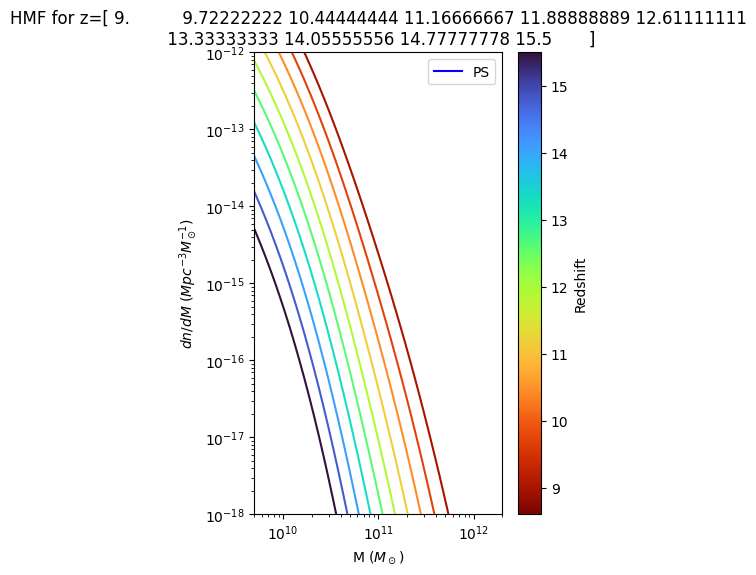

In [12]:
import matplotlib.cm as cm

plt.figure(figsize=(4, 6))

cmap = cm.turbo_r
norm = plt.Normalize(vmin=8.6, vmax=15.5)
colors = cmap(norm(z_range))

kh_results, pk_results = [], []
n_PS_results = []
for idx, z in enumerate(z_range):
    #compute the power spectrum for a given redshift
    kh, pk = compute_matter_power_spectrum(z)
    #and store it for later use
    kh_results.append(kh)
    pk_results.append(pk)
    
    n_PS_list = [compute_n_PS(M_list[i], R_list[i], kh_results[idx], pk_results[idx]) for i in range(len(M_list))]
    n_PS_results.append(n_PS_list)
    
    plt.loglog(M_list, n_PS_results[idx], color=colors[idx])

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Redshift')

plt.title(f"HMF for z={z_range}")
plt.loglog([], [], label='PS', color='blue')
plt.ylim([1e-18, 1e-12])
plt.xlim([5e9, 2e12])
plt.xlabel('M ($M_\odot$)')
plt.ylabel('$dn/dM \ (Mpc^{-3}M_\odot^{-1})$')
plt.legend()

plt.show()

### Let's now try to implement the Sheth and Tormen (ST) HMF

It is given by :

$\displaystyle n_{ST}(M)=A\sqrt{\frac{2a}{\pi}}\left| \frac{d\sigma}{dM} \right|\frac{\rho_0}{M}\left[ 1+\left( \frac{\sigma(M,z)^2}{a\delta_c^2} \right)^{0.3} \right]\frac{\delta_c}{\sigma(M,z)^2}\exp(-\frac{a\delta_c^2}{2\sigma(M,z)^2})$

with :

$a=0.707$ and $A=0.3222$.

In [13]:
def compute_n_ST(M,R,kh,pk):
    '''
    M in Msun
    R in Mpc/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    '''
    a=0.707
    A=0.3222
    
    sig_camb = compute_sig_camb(R, kh, pk)
    
    #dsig/dM = dsig/dR * dR/dM
    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    dR_dM =  (3/4/np.pi/rho_0_Msun_Mpch3)**(1/3) * M**(-2/3) / 3
    dsig_dM = dsig_dR * dR_dM    
    
    n_ST = A * np.sqrt(2*a/np.pi) * np.abs(dsig_dM) * (rho_0_Msun_Mpch3/h**3 / M) * (1+(sig_camb**2/a/delta_c**2)**0.3) * (delta_c / sig_camb**2) * np.exp(-a*delta_c**2 / 2 / sig_camb**2)
    return n_ST

/tmp/ipykernel_2814150/3381980077.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


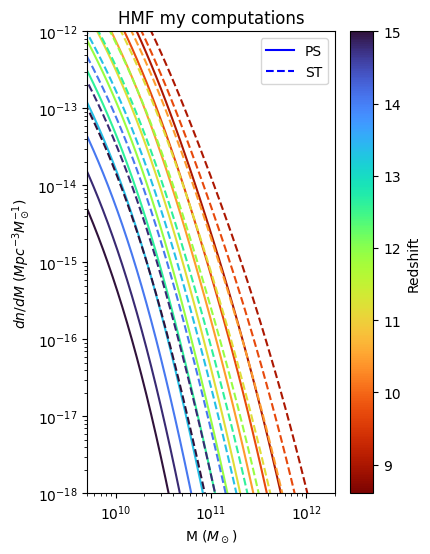

In [14]:
plt.figure(figsize=(4, 6))

cmap = cm.turbo_r
norm = plt.Normalize(vmin=8.6, vmax=15)
colors = cmap(norm(z_range))

n_ST_results = []
for idx, z in enumerate(z_range):
    #reuse the previously done computation stored in kh_results and pk_results
    plt.loglog(M_list, np.array(n_PS_results[idx]), color=colors[idx])
    
    n_ST_list = [compute_n_ST(M_list[i], R_list[i], kh_results[idx], pk_results[idx]) for i in range(len(M_list))]
    n_ST_results.append(n_ST_list)
    plt.loglog(M_list, np.array(n_ST_results[idx]), '--',color=colors[idx])

#  colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Redshift')

plt.title(f"HMF my computations")
plt.loglog([], [], '-', label='PS', color='blue')
plt.loglog([], [], '--', label='ST', color='blue')
plt.ylim([1e-18, 1e-12])
plt.xlim([5e9, 2e12])
plt.xlabel('M ($M_\odot$)')
plt.ylabel('$dn/dM \ (Mpc^{-3}M_\odot^{-1})$')
plt.legend()
plt.show()

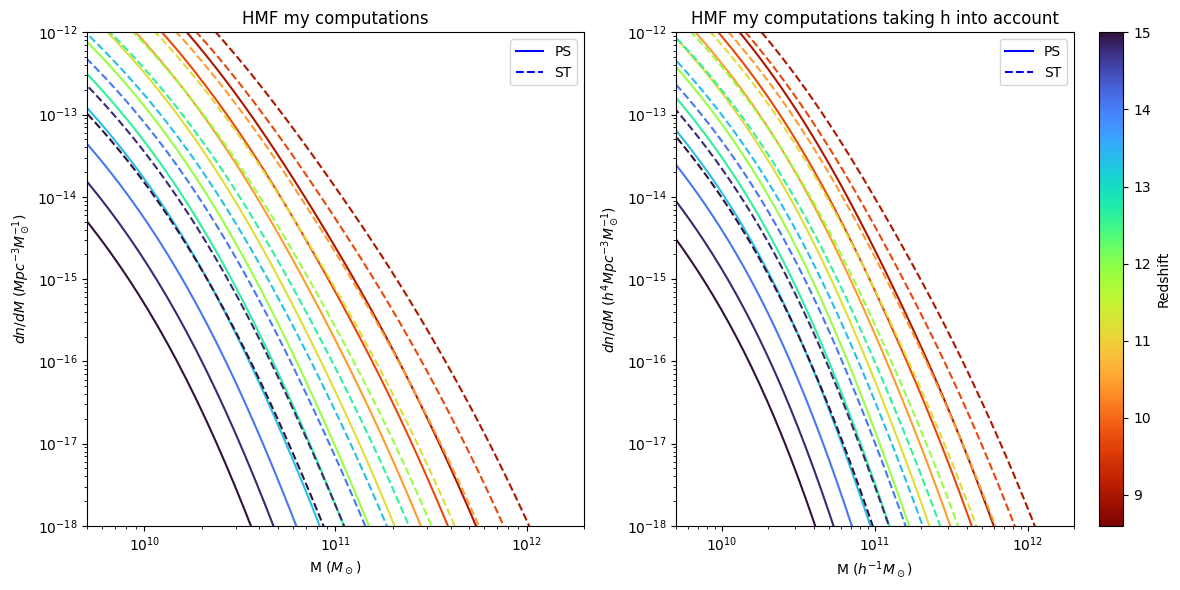

In [15]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

cmap = cm.turbo_r
norm = plt.Normalize(vmin=8.6, vmax=15)
colors = cmap(norm(z_range))

n_ST_results = []
for idx, z in enumerate(z_range):
    #reuse the previously done computation stored in kh_results and pk_results    
    n_ST_list = [compute_n_ST(M_list[i], R_list[i], kh_results[idx], pk_results[idx]) for i in range(len(M_list))]
    n_ST_results.append(n_ST_list)

for idx, z in enumerate(z_range):
    #reuse the previously done computation stored in kh_results and pk_results
    ax1.loglog(M_list, np.array(n_PS_results[idx]), '-', color=colors[idx])
    ax1.loglog(M_list, np.array(n_ST_results[idx]), '--',color=colors[idx])

ax1.loglog([], [], '-', label='PS', color='blue')
ax1.loglog([], [], '--', label='ST', color='blue')
ax1.set_title("HMF my computations")
ax1.set_ylim([1e-18, 1e-12])
ax1.set_xlim([5e9, 2e12])
ax1.set_xlabel(r'M ($M_\odot$)')
ax1.set_ylabel(r'$dn/dM \ (Mpc^{-3}M_\odot^{-1})$')
ax1.legend()

for idx, z in enumerate(z_range):
    #reuse the previously done computation stored in kh_results and pk_results
    ax2.loglog(M_list/h, np.array(n_PS_results[idx])*h**4, '-', color=colors[idx])
    ax2.loglog(M_list/h, np.array(n_ST_results[idx])*h**4, '--', color=colors[idx])

# colorbar for the second subplot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2) 
cbar.set_label('Redshift')

ax2.loglog([], [], '-', label='PS', color='blue')
ax2.loglog([], [], '--', label='ST', color='blue')
ax2.set_title("HMF my computations taking h into account")
ax2.set_ylim([1e-18, 1e-12])
ax2.set_xlim([5e9, 2e12])
ax2.set_xlabel(r'M ($h^{-1}M_\odot$)')
ax2.set_ylabel(r'$dn/dM \ (h^4Mpc^{-3}M_\odot^{-1})$')
ax2.legend()

plt.tight_layout()
plt.show()

### Making hmfcalc function

In [16]:
def hmfcalc(M,R,kh,pk,model):
    '''
    M in Msun
    R in Mpc/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    '''
    if model == "PS" :
        hmf = compute_n_PS(M, R, kh, pk)
    elif model == "ST":
        hmf = compute_n_ST(M, R, kh, pk)
    return hmf

Now using the hmf library to compare the results

### Trying to reproduce Fig 2 of A. Jenkins et al. (2000)

It's a CMF and not a HMF, let's introduce the Extended Press-Schechter CMF

In [17]:
def n_EPS(M, R, kh, pk, R0, delta_0):
    '''
    M in Msun
    R in Mpc/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    '''
    sig_camb = compute_sig_camb(R, kh, pk)
    sig_camb_0 = compute_sig_camb(R0, kh, pk)
    
    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    dR_dM =  (3/4/np.pi/rho_0_Msun_Mpch3)**(1/3) * M**(-2/3) / 3
    dsig_dM = dsig_dR * dR_dM
    
    n_EPS = np.sqrt(2/np.pi) * np.abs(dsig_dM) * (rho_0_Msun_Mpch3 / M) * (sig_camb*(delta_c-delta_0) /(sig_camb**2-sig_camb_0**2)**(-3/2)) * np.exp(-delta_c**2 / 2 / (sig_camb**2-sig_camb_0**2))
    return n_EPS

We want to compute $dn/d\log_{10}M$ :
and we know how to compute dn/dM, we simply have :

$\displaystyle \frac{dn}{d\log_{10}M} = \frac{dn}{dM} \times \frac{dM}{d\log_{10}M}$

Since

$\displaystyle d\log_{10}M = \frac{dM}{M \ln(10)}$

we obtain

$\displaystyle \frac{dM}{d\log_{10}M} = M \ln(10)$

Thus:

$\displaystyle \frac{dn}{d\log_{10}M} = \frac{dn}{dM} \times M \ln(10)$



Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


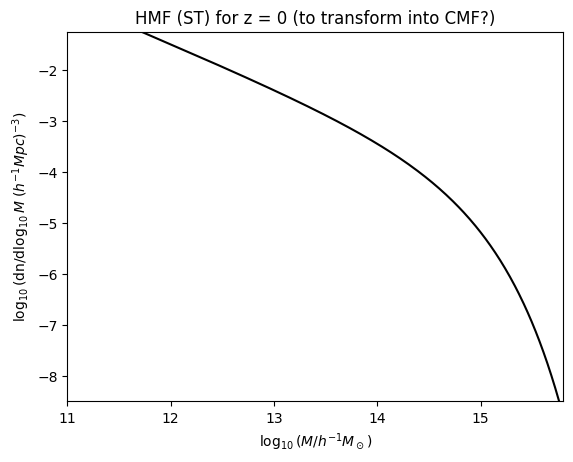

In [18]:
M0_list = np.linspace(11.25,16,500) #M in M_sun
M0_list = 10**M0_list
R0_list = (3*M0_list/(4*np.pi*rho_0_Msun_Mpch3))**(1/3) # in Mpc/h

kh0,pk0=compute_matter_power_spectrum(0.0, H0=70, ob=0.02/h**2, ns=1) # "ob = 0.0196 (Burles and Tytler 1998). In all models, the slope of the primordial power spectrum was taken to be unity."
dn_dlog10M_list = [compute_n_ST(M0_list[i], R0_list[i], kh0, pk0)*M0_list[i]*np.log(10) for i in range(len(M0_list))]

plt.plot(np.log10(M0_list*h), np.log10(dn_dlog10M_list),'k')

plt.title(f"HMF (ST) for z = 0 (to transform into CMF?)")
plt.ylim([-8.5, -1.25])
plt.xlim([11, 15.8])
plt.xlabel('$\log_{10}(M/h^{-1}M_\odot$)')
plt.ylabel('$\log_{10}($dn/d$\log_{10}M \ (h^{-1}Mpc)^{-3})$')
plt.show()

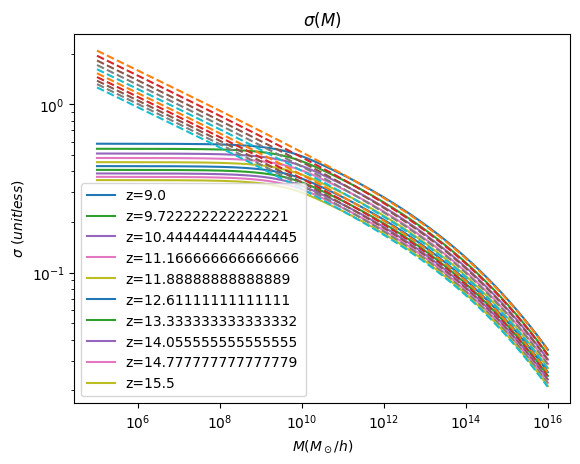

In [19]:
from hmf import MassFunction

Msmin = 5
Msmax = 16

rho_0 = om * 3 * (H0*1e3/Mpc_to_m)**2 / 8 / np.pi / G # mean density in kg/m^-3
rho_0_Msun_Mpc3 = rho_0/(M_sun)*(Mpc_to_m)**3 # mean density in Msun/Mpc^3 
rho_0_h2_Msun_Mpc3 = rho_0/(M_sun/h)*(Mpc_to_m/h)**3 # mean density in Msun/Mpc^3 

mf_temp = MassFunction(Mmin=Msmin, Mmax=Msmax, n=ns, sigma_8=s8, z=0, delta_c=delta_c, cosmo_params={"H0":H0, "Om0":om, "Ob0":ob}, hmf_model="PS")

Ms_list = np.linspace(Msmin,Msmax,len(mf_temp.m)) #M in M_sun/h
Ms_list = 10**Ms_list
Rs_list = (3*Ms_list/(4*np.pi*rho_0_h2_Msun_Mpc3))**(1/3) # in Mpc/h

for idx, z in enumerate(z_range):
    mf_temp.update(z=z)
    sigma0_list = [compute_sig_camb(Rs_list[i], kh_results[idx],pk_results[idx]) for i in range(len(mf_temp.m))]

    # plt.loglog(M0_list, sigma0_list,'-', label="My computations")
    # plt.loglog(mf_ST.m, mf_ST.sigma, '--', label="HMF library")
    plt.loglog(Ms_list, sigma0_list,'-', label=f"z={z}")
    plt.loglog(mf_temp.m, mf_temp.sigma, '--')

plt.title(f"$\sigma(M)$")
plt.xlabel('$M (M_\odot/h$)')
plt.ylabel('$\sigma \ (unitless)$')
plt.legend()
plt.show()